# 4. Student-Centric Descriptive Analysis

In [1]:
import pandas as pd
import numpy as np
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, LinearAxis, Range1d, Span, Label, LabelSet
from bokeh.layouts import gridplot, column
from bokeh.palettes import Spectral8, Pastel1
from bokeh.transform import cumsum
import ipywidgets as widgets
from ipywidgets import interact

data = pd.read_csv('/Users/rachel/Library/CloudStorage/Dropbox-TLPSummerInterns/TLP Summer Intern Folder/Zhou/CODE - MPS_data_july_2023/mps_student_activity.tsv', sep='\t', on_bad_lines='skip')
data_detail = pd.read_csv('/Users/rachel/Library/CloudStorage/Dropbox-TLPSummerInterns/TLP Summer Intern Folder/Zhou/CODE - MPS_data_july_2023/mps_student_activity_detail.tsv', sep='\t',on_bad_lines='skip')
ddata_assessment = pd.read_csv('/Users/rachel/Library/CloudStorage/Dropbox-TLPSummerInterns/TLP Summer Intern Folder/Zhou/CODE - MPS_data_july_2023/mps_assessments.tsv', sep='\t',on_bad_lines='skip')

## 4.1 Activity Performance Analysis

### Activity Result Distributions

In [2]:
import matplotlib.pyplot as plt
order = ['Optimal', 'Pass (Not Optimal)', 'Failed', 'Special']

# Categorizing the test results based on the provided breakdown
def categorize_test_result(result):
    if result < 20 and result != -1:
        return 'Failed'
    elif 20 <= result < 30:
        return 'Pass (Not Optimal)'
    elif 30 <= result < 1000:
        return 'Optimal'
    else:
        return 'Special'


def plot_test_results_updated(data):
    data['test_result_category'] = data['best_result'].apply(categorize_test_result)

    test_result_counts = data['test_result_category'].value_counts()
    test_result_counts = test_result_counts[order]

    # Preparing the labels with both percentage and absolute count
    total_count = test_result_counts.sum()
    labels = [f"{label}\n{count} entries ({count/total_count:.1%})" for label, count in zip(test_result_counts.index, test_result_counts)]
    
    colors = Spectral8[1:len(test_result_counts)+1]
    explode = [0, 0, 0, 0.05]

    plt.figure(figsize=(8, 5))
    wedges, texts = plt.pie(test_result_counts, 
                            labels=labels, 
                            startangle=140,
                            colors=colors,
                            wedgeprops=dict(width=0.25),
                            textprops=dict(color="black"),
                            explode= explode
                            )

    plt.setp(texts, size=7)

    # Adding a legend
    plt.legend(wedges, test_result_counts.index,
              title="Test Results",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1),fontsize=8)

    plt.title('Distribution of Test Results', fontsize=14)
    plt.tight_layout()
    plt.show()


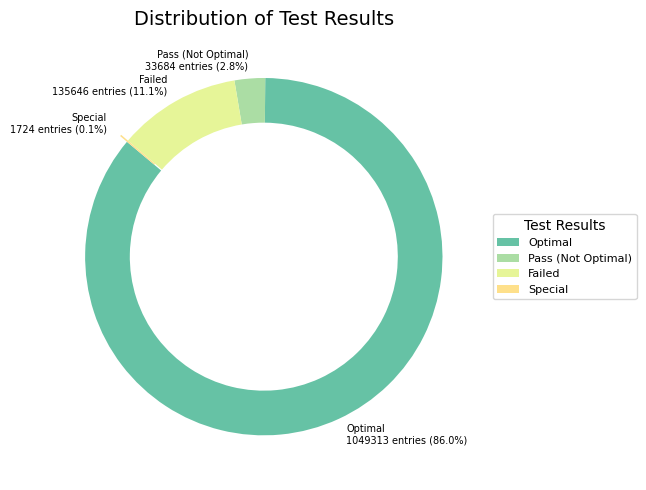

In [3]:
plot_test_results_updated(data_detail)

`````{admonition} Insights
:class: tip
The majority of students have achieved an ‘Optimal’ result on their best attempt, as indicated by the largest portion of the pie chart. However, there is still over 10% of activities that resulted in a pass or suboptimal outcome, suggesting that there is room for improvement and support.
`````
In conclusion, the majority of students on the platform are performing well, with a significant proportion achieving optimal results. However, there is always room for improvement. By focusing on the segments that are not achieving optimal scores and understanding their needs, the platform can further enhance its overall effectiveness and student success rates.

### Course-Wise Activity Result Distributions

The Stacked 100% Bar Chart illustrates the proportional distribution of test results across different courses. Each course's bar is normalized to sum up to 100%, making it easier to compare the distribution of test results across courses.

In [4]:
course_name_map = {
        'csf': 'CS Fundamentals (K-5)',
        'csd': 'CS Discoveries (6-10)',
        'csp': 'CS Principles (AP)',
    }

def plot_stacked_bar_chart(data):
    data_detail['test_result_category'] = data_detail['best_result'].apply(categorize_test_result)
    
    grouped_data = data.groupby('course_name')['test_result_category'].value_counts().unstack().fillna(0)
    # Normalize the data to get proportions
    grouped_data_normalized = grouped_data.div(grouped_data.sum(axis=1), axis=0)
    grouped_data_normalized = grouped_data_normalized.reindex(list(course_name_map.keys()))
    
    # Stacked 100% Bar Chart
    ax = grouped_data_normalized[order].plot(kind='bar', stacked=True, figsize=(8, 5), color=Spectral8[1:5])
    ax.set_title('Stacked Proportional Distribution of Test Results by Course', fontsize=14)
    ax.set_xlabel('Course Name', fontsize=10)
    ax.set_ylabel('Proportion of Students', fontsize=10)
    ax.set_xticklabels([course_name_map[course_code] for course_code in grouped_data_normalized.index], rotation=0)
    ax.legend(title="Test Result Categories")
    ax.grid(axis='y')
    plt.tight_layout()
    plt.show()

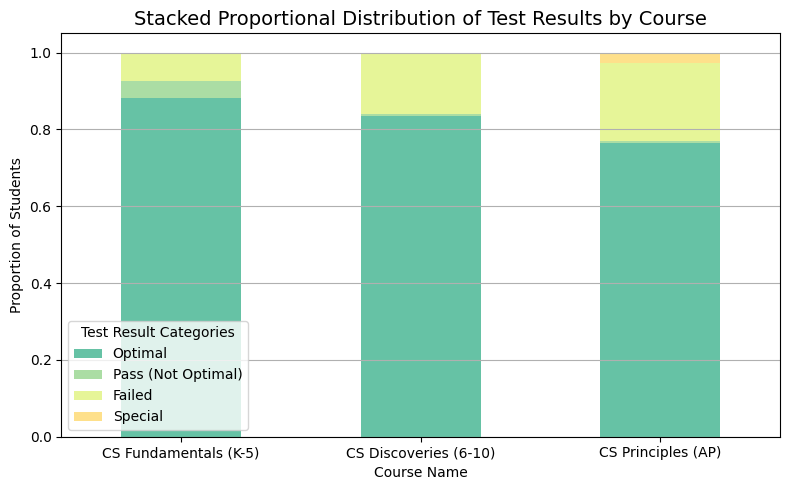

In [5]:
plot_stacked_bar_chart(data_detail)

The majority of students across all courses have "Optimal" results. As the course level advances, there's a slight increase in students who failed, indicating potential areas for additional support mechanisms. Further analysis might be beneficial to understand the specific challenges faced by students in the "Pass (Not Optimal)" category. For instance, are there specific topics or modules within the courses where students consistently struggle?

### Find most difficult scripts and questions

The {code}`find_difficult_interactive` function is designed to help educators and course designers identify levels where students often face difficulties. By leveraging user interaction, this tool provides a flexible approach to hone in on specific areas of interest and concern.

How to Use:
Course Dropdown: Select a course of interest from the dropdown menu.

Threshold Slider: Adjust the slider to set the minimum number of attempts for a level to be considered in the analysis. This helps in filtering out levels with very few attempts which might skew the failure rate.

Num Records Slider: Determine how many of the top challenging levels you wish to see. Slide to choose anywhere from 1 to 30 records.

Start Year and End Year Dropdowns: Choose a range of school years for which you'd like to analyze the data.

After setting your preferences, the function will display a dataframe that showcases the most challenging levels based on the specified criteria.

```{note}
this function removes levels with the name "survey" as they typically represent preliminary assessments or questionnaires that aren't necessarily indicative of the actual course content difficulty.
```

In [6]:
def find_difficult(data, threshold=100, num_records=10):
    data = data[~data['level_name'].str.contains('survey', case=False, na=False)].copy()
    data['test_result_category'] = data['best_result'].apply(categorize_test_result)
    
    # Calculating failure rate and total attempts for each script and level combination
    agg_dict = {
        'test_result_category': lambda x: (x == 'Failed').sum() / len(x),
        'level_name': 'size'
    }
    
    script_fail_rates = data.groupby(['script_name', 'level_name']).agg(agg_dict)
    script_fail_rates.columns = ['fail_rate', 'total_attempts']
    script_fail_rates.reset_index(inplace=True)
    
    filtered_scripts = script_fail_rates[script_fail_rates['total_attempts'] > threshold]
    sorted_scripts = filtered_scripts.sort_values(by=['fail_rate', 'total_attempts'], ascending=False)
    
    return sorted_scripts.head(num_records)

def find_difficult_interactive(course_name='CS Fundamentals (K-5)', threshold=100, num_records=10, start_date='2015-16', end_date='2021-22'):
    # Reverse mapping from the friendly course name to its abbreviated code
    reverse_course_name_map = {v: k for k, v in course_name_map.items()}
    course_code = reverse_course_name_map[course_name]
    
    filtered_data = data_detail[(data_detail['course_name'] == course_code) & 
                                (data_detail['school_year'] >= start_date) & 
                                (data_detail['school_year'] <= end_date)]
    
    result = find_difficult(filtered_data, threshold, num_records)
    
    return result

course_dropdown = widgets.Dropdown(options=list(course_name_map.values()), description='Course:')
threshold_slider = widgets.IntSlider(min=0, max=500, step=10, value=100, description='Threshold:')
num_records_slider = widgets.IntSlider(min=1, max=30, step=1, value=10, description='Num Records:')
start_year_dropdown = widgets.Dropdown(options=sorted(data_detail['school_year'].unique().tolist()), description='Start Year:')
end_year_dropdown = widgets.Dropdown(options=sorted(data_detail['school_year'].unique().tolist()), description='End Year:')
# Set the maximum column width to a higher value
pd.set_option('display.max_colwidth', 180)

interact(find_difficult_interactive, course_name=course_dropdown, threshold=threshold_slider, num_records=num_records_slider, start_date=start_year_dropdown, end_date=end_year_dropdown);


interactive(children=(Dropdown(description='Course:', options=('CS Fundamentals (K-5)', 'CS Discoveries (6-10)…

1. **Identify Challenging Topics**: The primary goal is to identify which levels or topics students are struggling with the most. High failure rates can indicate that the material is too challenging, or perhaps not explained clearly enough.

2. **Course Design Improvements**: By spotting these challenging areas, educators can focus on refining course content, providing additional resources, or even restructuring the lessons for better clarity.

3. **Targeted Support**: Tutors and educators can offer additional support or tutorials on these identified levels to assist students in overcoming these challenges.

4. **Data-Driven Decisions**: Instead of relying on anecdotal evidence or assumptions, this tool provides a data-driven approach to understand student performance and behavior.

## 4.2 Retention Rate and Drop-Out

## 4.3 Engagement Analysis

### Time Gap

## 4.2 Assessment Analysis